<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/WS04_wkshp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# !pip install folium

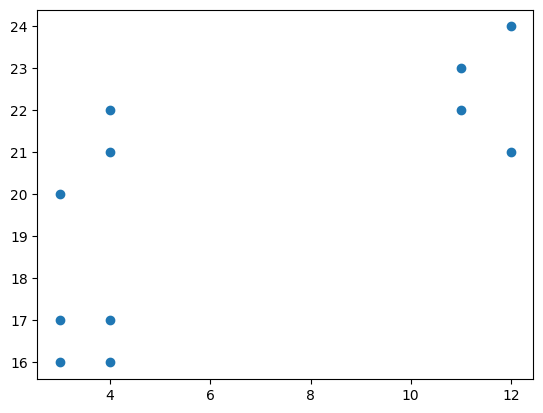

In [17]:
import matplotlib.pyplot as plt

x = [4, 3,4, 3, 4, 3, 11, 12 , 4, 11, 12]
y = [21,20,22, 17, 17, 16, 23, 24, 16, 22, 21]

plt.scatter(x, y)
plt.show()

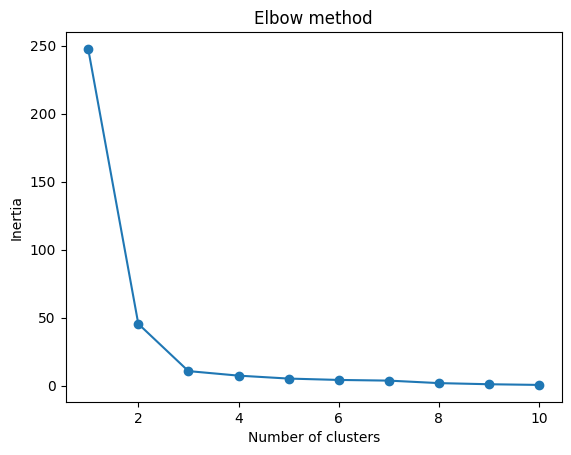

In [18]:
from sklearn.cluster import KMeans

data = list(zip(x, y))
results = []

for i in range(1,11):
    #init:The standard version of the k-means algorithm is implemented by setting init to "random" .
    #Setting this to "k-means++" employs an advanced trick to speed up convergence
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=42)
    #random_state: This is setting a random seed. It is useful if we want to reproduce exact clusters over and over again.
    #We can set it to any number we want.
    kmeans.fit(data)#computes the cluster centers
    results.append(kmeans.inertia_)

plt.plot(range(1,11), results, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

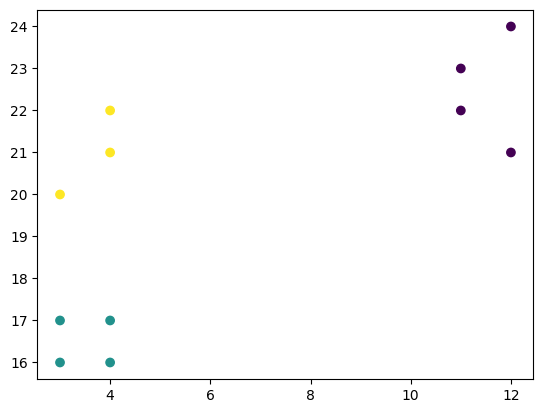

In [19]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data) #computes the cluster centers

plt.scatter(x, y, c=kmeans.labels_)
plt.show()

In [20]:
#Original

import pandas as pd
import numpy as np
import requests
from io import StringIO
import folium
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Fetch Latest COVID-19 Data from GitHub ----
#base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
#latest_date = "02-13-2020.csv"  # Update with the latest date in MM-DD-YYYY format
#url = base_url + latest_date
#print(url)


In [21]:
# ---- Step 1: Load the Dataset ----
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/01-02-2023.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './data/01-02-2023.csv'  # Local path

Mounted at /content/drive


               FIPS          Lat        Long_     Confirmed         Deaths  \
count   3268.000000  3925.000000  3925.000000  4.016000e+03    4016.000000   
mean   32405.943390    35.736183   -71.109728  1.646409e+05    1667.277141   
std    18056.381177    13.441327    55.361480  1.046512e+06    8705.465768   
min       60.000000   -71.949900  -178.116500  0.000000e+00       0.000000   
25%    19048.500000    33.191535   -96.595639  3.737500e+03      46.000000   
50%    30068.000000    37.895700   -86.717326  1.050600e+04     130.500000   
75%    47041.500000    42.176955   -77.357900  4.577550e+04     465.250000   
max    99999.000000    71.706900   178.065000  3.830609e+07  183348.000000   

       Recovered  Active  Incident_Rate  Case_Fatality_Ratio  
count        0.0     0.0    3922.000000          3974.000000  
mean         NaN     NaN   27693.653663             3.396156  
std          NaN     NaN   10388.048975            93.482133  
min          NaN     NaN       0.000000      

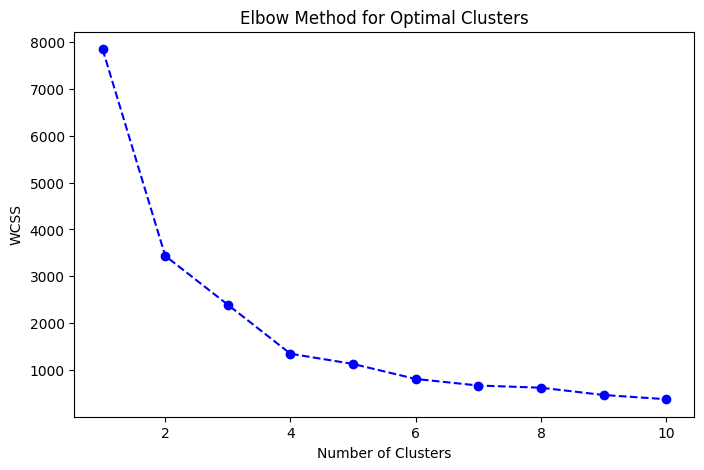

In [22]:

# Load dataset
df = pd.read_csv(file_path)
print(df.describe())
df.head(1)
# ---- Data Preprocessing ----
# Select relevant columns
print(df.columns)  # Verify column names
columns_to_use = ["Country_Region", "Province_State", "Lat", "Long_", "Confirmed", "Deaths", "Recovered", "Active"]
df = df[columns_to_use]

# Handle missing values
#Replace NULL values with 0
df.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)
df.dropna(subset=['Lat', 'Long_'], inplace=True)

# Normalize data for clustering
#StandardScaler, a popular preprocessing technique provided by scikit-learn, offers a simple yet effective method for standardizing feature values
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["Confirmed", "Deaths", "Recovered", "Active"]])

# ---- Apply K-Means Clustering ----
optimal_clusters = 5  # Change based on analysis
kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", max_iter=300, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# ---- Visualizing Clusters on a World Map ----
world_map = folium.Map(location=[20, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(world_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long_"]],
        popup=f"Country: {row['Country_Region']}<br>Confirmed: {row['Confirmed']}<br>Deaths: {row['Deaths']}<br>Recovered: {row['Recovered']}",
        icon=folium.Icon(color=["red", "blue", "green", "purple", "orange"][row["Cluster"]])
    ).add_to(marker_cluster)

# Save map to an HTML file
world_map.save("covid19_clusters_map.html")
print("✅ World Map with Clusters Saved as 'covid19_clusters_map.html'")
#print("✅ Map saved successfully!")

# Open the saved file in Jupyter Notebook
import webbrowser
webbrowser.open("covid19_clusters_map.html")


# ---- Clustering Insights ----
print("\n📌 **Cluster Analysis Summary:**")
print(df.groupby("Cluster")[["Confirmed", "Deaths", "Recovered", "Active"]].mean())

# ---- Elbow Method to Find Optimal Clusters ----
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='blue')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()


In [23]:
import pandas as pd #For working with data sets.
import numpy as np
import requests
from io import StringIO
import folium #It helps you create several types of maps
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler #We will use this to normalize data for clustering
import matplotlib.pyplot as plt
import seaborn as sns #data visualization library based on matplotlib

# ---- Fetch Latest COVID-19 Data from GitHub ----
#base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"
#latest_date = "02-13-2020.csv"  # Update with the latest date in MM-DD-YYYY format
#url = base_url + latest_date
#print(url)


In [24]:
# Load dataset
#https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
df = pd.read_csv(file_path)
print(df.describe())
df.head(1)

               FIPS          Lat        Long_     Confirmed         Deaths  \
count   3268.000000  3925.000000  3925.000000  4.016000e+03    4016.000000   
mean   32405.943390    35.736183   -71.109728  1.646409e+05    1667.277141   
std    18056.381177    13.441327    55.361480  1.046512e+06    8705.465768   
min       60.000000   -71.949900  -178.116500  0.000000e+00       0.000000   
25%    19048.500000    33.191535   -96.595639  3.737500e+03      46.000000   
50%    30068.000000    37.895700   -86.717326  1.050600e+04     130.500000   
75%    47041.500000    42.176955   -77.357900  4.577550e+04     465.250000   
max    99999.000000    71.706900   178.065000  3.830609e+07  183348.000000   

       Recovered  Active  Incident_Rate  Case_Fatality_Ratio  
count        0.0     0.0    3922.000000          3974.000000  
mean         NaN     NaN   27693.653663             3.396156  
std          NaN     NaN   10388.048975            93.482133  
min          NaN     NaN       0.000000      

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incident_Rate,Case_Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2023-01-03 04:21:07,33.93911,67.709953,207627,7849,NaN,NaN,Afghanistan,533.356919,3.780337


In [25]:
# ---- Data Preprocessing ----
# Select relevant columns
print(df.columns)  # Verify column names
columns_to_use = ["Country_Region", "Province_State", "Lat", "Long_", "Confirmed", "Deaths", "Recovered", "Active"]
df = df[columns_to_use]


Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio'],
      dtype='object')


In [26]:
#Handle missing values
#Replace NULL values with 0
df.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)
df.dropna(subset=['Lat', 'Long_'], inplace=True)

# Normalize data for clustering
#StandardScaler, a popular preprocessing technique provided by scikit-learn, offers a simple yet effective method for standardizing feature values
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["Confirmed", "Deaths", "Recovered", "Active"]])



<ipython-input-26-d3c7bf3a957c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}, inplace=True)
<ipython-input-26-d3c7bf3a957c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Lat', 'Long_'], inplace=True)


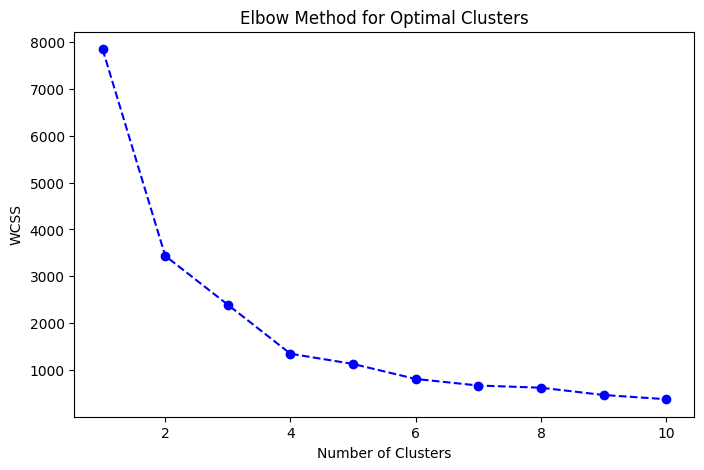

In [27]:
# ---- Elbow Method to Find Optimal Clusters ----
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=42)
    kmeans.fit(df_scaled) #computes the cluster centers
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='blue')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()


In [28]:
# ---- Apply K-Means Clustering ----
optimal_clusters = 5  # Change based on analysis
kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", max_iter=300, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled) #computes the cluster centers also returns the cluster labels for each data point



In [29]:
# ---- Visualizing Clusters on a World Map ----
world_map = folium.Map(location=[20, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(world_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row["Lat"], row["Long_"]],
        popup=f"Country: {row['Country_Region']}<br>Confirmed: {row['Confirmed']}<br>Deaths: {row['Deaths']}<br>Recovered: {row['Recovered']}",
        icon=folium.Icon(color=["red", "blue", "green", "purple", "orange"][row["Cluster"]])
    ).add_to(marker_cluster)

# Save map to an HTML file
world_map.save("covid19_clusters_map.html")
print("✅ World Map with Clusters Saved as 'covid19_clusters_map.html'")
#print("✅ Map saved successfully!")

# Open the saved file in Jupyter Notebook
import webbrowser
webbrowser.open("covid19_clusters_map.html")



✅ World Map with Clusters Saved as 'covid19_clusters_map.html'


False

In [30]:

# ---- Clustering Insights ----
print("\n📌 **Cluster Analysis Summary:**")
print(df.groupby("Cluster")[["Confirmed", "Deaths", "Recovered", "Active"]].mean())




📌 **Cluster Analysis Summary:**
            Confirmed         Deaths  Recovered  Active
Cluster                                                
0        7.083671e+04     762.828504        0.0     0.0
1        6.401312e+06  134833.375000        0.0     0.0
2        3.376334e+07   95469.000000        0.0     0.0
3        2.813963e+06   26374.573171        0.0     0.0
4        1.871753e+07  142420.000000        0.0     0.0


In [31]:
df = pd.read_csv('F:\A-universities\WLV\workshop\Week 4\country_wise_latest.csv')
print(df.describe())
df.head(1)
# ---- Data Preprocessing ----
# Select relevant columns
print(df.columns)  # Verify column names

columns_to_use = ["Country/Region", "Confirmed", "Deaths", "Recovered", "Active", "New cases","New deaths", "New recovered"]
df = df[columns_to_use]

#Handle missing values
#Replace NULL values with 0
df.fillna({'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0, 'New cases':0, 'New deaths':0, 'New recovered':0 }, inplace=True)
df.dropna(subset=['Country/Region'], inplace=True)

# Normalize data for clustering
#StandardScaler, a popular preprocessing technique provided by scikit-learn, offers a simple yet effective method for standardizing feature values
#scaler = StandardScaler()
#df_scaled = scaler.fit_transform(df[["Confirmed", "Deaths", "Recovered", "Active", "New cases","New deaths", "New recovered"]])

FileNotFoundError: [Errno 2] No such file or directory: 'F:\\A-universities\\WLV\\workshop\\Week 4\\country_wise_latest.csv'

In [ ]:
# Normalize data for clustering
#StandardScaler, a popular preprocessing technique provided by scikit-learn, offers a simple yet effective method for standardizing feature values
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[["New cases","New deaths", "New recovered"]])

# ---- Elbow Method to Find Optimal Clusters ----
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='blue')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()



In [ ]:
# ---- Apply K-Means Clustering ----
optimal_clusters = 6  # Change based on analysis
kmeans = KMeans(n_clusters=optimal_clusters, init="k-means++", max_iter=300, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)


# ---- Clustering Insights ----
print("\n📌 **Cluster Analysis Summary:**")
print(df.groupby("Cluster")[["New cases","New deaths", "New recovered"]].mean())



In [ ]:
def CountFrequency(my_list):
    freq = {}
    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1

    for key, value in freq.items():
        print ("% d : % d"%(key, value))

In [ ]:
CountFrequency(kmeans.labels_)

In [ ]:
for index, row in df.iterrows():
    if row['Country/Region']=="Peru":
        cluster_i=row['Cluster']
        break
print(cluster_i)

In [ ]:
for index, row in df.iterrows():
    if row['Cluster']==0:
        print(row['Country/Region'])


In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:
!pip install geopy

In [ ]:
from geopy.geocoders import Nominatim
import time
#Geolocation is a simple and clever application which uses google maps api.
#This application allows you to easily and quickly get information about given localisation.
geolocator = Nominatim(user_agent="Vahid Rafe")
lati=[]
longi=[]
counter=0
for index, row in df.iterrows():
    time.sleep(2)
    i=row['Country/Region']

    print(counter, ": This is:   ", i)
    if i != None:

        location = geolocator.geocode(i)
        if location!=None:
            lati.append(location.latitude)
            longi.append(location.longitude)
        else:
            lati.append(float("Nan"))
            longi.append(float("Nan"))
        print(lati[counter], longi[counter], i)
        counter=counter+1

    else:
        print("Nothing")
        lati.append(float("Nan"))
        longi.append(float("Nan"))
        print(lati[counter], longi[counter], i)
        counter=counter+1





In [ ]:
df['Country/Region']

In [ ]:
df['lat']=lati
df['long']=longi
for index, row in df.iterrows():
    print(row['Country/Region'], row['lat'])

In [ ]:
# ---- Visualizing Clusters on a World Map ----
world_map = folium.Map(location=[20, 0], zoom_start=2)

marker_cluster = MarkerCluster().add_to(world_map)

for _, row in df.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"Country: {row['Country/Region']}<br>New cases: {row['New cases']}<br>New Deaths: {row['New deaths']}<br>New Recovered: {row['New recovered']}",
        icon=folium.Icon(color=["red", "blue", "green", "purple", "orange", "black"][row["Cluster"]])
    ).add_to(marker_cluster)

# Save map to an HTML file
world_map.save("covid18_clusters_map.html")
print("✅ World Map with Clusters Saved as 'covid18_clusters_map.html'")
#print("✅ Map saved successfully!")

# Open the saved file in Jupyter Notebook
import webbrowser
webbrowser.open("covid18_clusters_map.html")